In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Stepy Tutorial
Stepy is a python package for identifying and fitting steps in single-molecule traces. This tutorial will show you how to use it. 

First let's load in some simulated data. This data has a linear step at time 4 with an amplitude of 2 and width of 1 with gaussian noise partially obscuring the step, similar to what you might find in a single-molecule trace.

Text(0, 0.5, 'Signal')

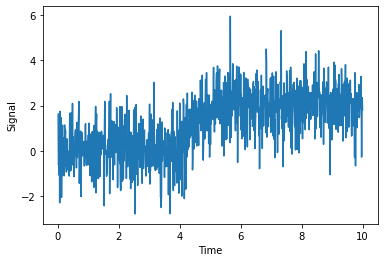

In [11]:
path = '../data/linstep.npz'
time,trace = np.loadtxt(path)
plt.plot(time,trace)
plt.xlabel('Time')
plt.ylabel('Signal')

Now, let's load fit_signal from the Stepy methods. This fit_signal method automatically applies the t-test method to look for steps at each timepoint. These steps are identified by comparing some number of points before and after the timepoint and evaluating the likelihood that their mean is different using a two-sample Student's t-test.

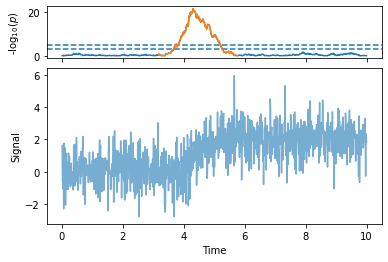

In [18]:
from stepy.methods import fit_signal
# Find the sampling rate
dt = time[1] - time[0]
# Look for steps in the trace
fs = fit_signal(trace,dt=dt)
# Plot the trace and the results of the t-test method
fs.plot()


The fit_signal method calculates the negative log likelihood of there being no step at each point - i.e., the higher the negative log likelihood the more likely there is a step. The negative log likelihood is calculated by comparing a window_length number of points before and after each timepoint with the two-sample Student's. 

The negative log likelihood is shown in the upper plot. On the plot, there are also two horizontal dashed lines. The lower horizontal dashed line represents the minimum threshold. The minimum threshold is used to find possible step regions above the background noise. The upper horizontal dashed line represents the maximum threshold. Possible step regions must  have at least one timepoint with a negative log likelihood above the maximum threshold for it to be considered a step.

The window_length, minimum threshold, and maximum threshold are all parameters that can be adjusted to identify steps. The default values for these parameters are 100, 3, and 5. Let's look at what happens when we adjust these parameters.


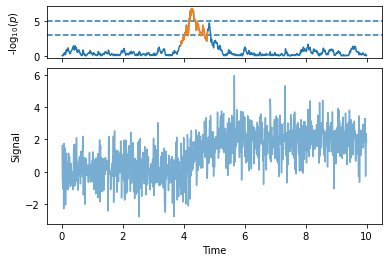

In [19]:
# Look for steps in the trace
fs = fit_signal(trace,dt=dt,window_length=50)
# Plot the trace and the results of the t-test method
fs.plot()

Adjusting the window length to 50 points still catches the step, but the width of the region with the step is much smaller because of the default thresholds. This might cause problems when fitting. To adjust for this, we can lower the minimum threshold.

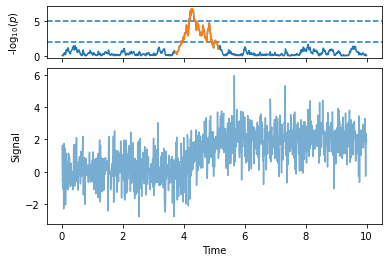

In [20]:
# Look for steps in the trace
fs = fit_signal(trace,dt=dt,window_length=50,min_threshold=2)
# Plot the trace and the results of the t-test method
fs.plot()

Lowering the minimum threshold catches more of the region with the step.

We can also lower the maximum threshold.

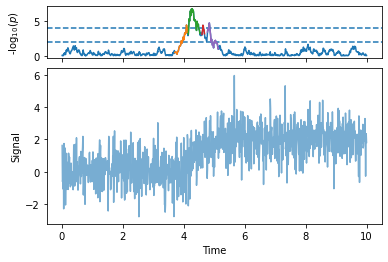

In [21]:
# Look for steps in the trace
fs = fit_signal(trace,dt=dt,window_length=50,min_threshold=2,max_threshold=4)
# Plot the trace and the results of the t-test method
fs.plot()

Lowering the maximum threshold in this case causes problems. Although there is only one step, the noise within the step regions causes there to be multiple peaks that are now above the maximum threshold and get identified as a step.  

If you need to keep a lower maximum threshold but don't want to catch all of these peaks, you can increase the minimum threshold. The minimum threshold sets the background level of noise.

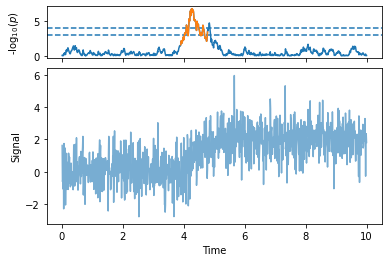

In [22]:
# Look for steps in the trace
fs = fit_signal(trace,dt=dt,window_length=50,min_threshold=3,max_threshold=4)
# Plot the trace and the results of the t-test method
fs.plot()

Once again, the method identifies a single step but at the cost of a narrower step region. This is more likely to be a problem if there are slow increases in the signal during which there is also significant noise. 

## Fitting a step

Now, that we've covered the basics of the t-test method, let's fit the step that fit_signal identified.

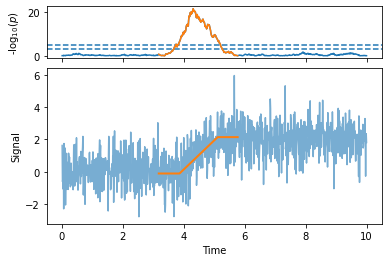

In [43]:
# Look for steps in the trace
fs = fit_signal(trace,dt=dt)
# Fit the step
fs.fit()
# Plot the trace and the results of the t-test method
fs.plot()

By eye, the fit looks very good, but let's take a look at the fit report. 

In [29]:
fs.print_fit_report()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 260
    # variables        = 4
    chi-square         = 277.386706
    reduced chi-square = 1.08354182
    Akaike info crit   = 24.8300478
    Bayesian info crit = 39.0727743
[[Variables]]
    s0_c:         -0.11233718 +/- 0.12531362 (111.55%) (init = 0.09542509)
    s0_amplitude:  2.25423820 +/- 0.17922278 (7.95%) (init = 1.922531)
    s0_center:     3.86242100 +/- 0.12486941 (3.23%) (init = 4.31)
    s0_sigma:      1.25143526 +/- 0.20501904 (16.38%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0_center, s0_sigma)     = -0.819
    C(s0_c, s0_amplitude)      = -0.699
    C(s0_c, s0_center)         = 0.557
    C(s0_amplitude, s0_sigma)  = 0.485
    C(s0_amplitude, s0_center) = -0.390
    C(s0_c, s0_sigma)          = -0.339


The fit report contains a lot of information, but let's just take a look at the fit statistics for now. The most basic way to evaluate the fit is the reduced chi-square value, which should be close to one if the fit explains the data well. Out fit has a reduced chi-square value of 1.08, which means it does very well. 

You can also directly access the parameters values (and their associated errors) in several ways.

In [40]:
# Get each parameter value and standard error individually
for name, param in fs.output.params.items():
    print(name,param.value,param.stderr)
# Get a dictionary of the parameter values
fs.output.params.valuesdict()


s0_c -0.11233717860843578 0.12531362414949443
s0_amplitude 2.2542381985967435 0.17922278202056413
s0_center 3.8624209986987132 0.12486941180566513
s0_sigma 1.2514352630484058 0.20501904224708362


{'s0_c': -0.11233717860843578,
 's0_amplitude': 2.2542381985967435,
 's0_center': 3.8624209986987132,
 's0_sigma': 1.2514352630484058}

## Other types of steps
Often times, steps in single-molecule traces are instantaneous. More accurately, they occur faster than the measurement timescale, making them effectively instantaneous. In these cases, it may be advantageous to fix the step width to be 0 rather than to have it as a free parameter.

To show how to do this, let's load in some simulated data with an instantaneous step. In this data, the step occurs at time 4 and increases the signal by 2.

Text(0, 0.5, 'Signal')

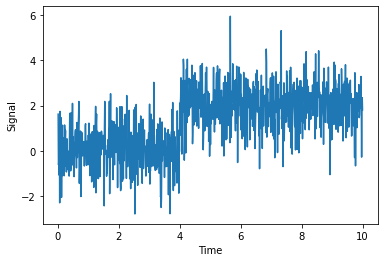

In [45]:
path = '../data/intstep.npz'
time,trace = np.loadtxt(path)
plt.plot(time,trace)
plt.xlabel('Time')
plt.ylabel('Signal')

As before, we'll use the t-test method to find the step and then fit it.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 95
    # data points      = 231
    # variables        = 4
    chi-square         = 231.322463
    reduced chi-square = 1.01904169
    Akaike info crit   = 8.32223790
    Bayesian info crit = 22.0919087
[[Variables]]
    s0_c:         -0.04995809 +/- 0.09624976 (192.66%) (init = 0.1062227)
    s0_amplitude:  2.09121867 +/- 0.13434604 (6.42%) (init = 1.938494)
    s0_center:     3.97000095 +/- 0.02723160 (0.69%) (init = 3.98)
    s0_sigma:      0.05356892 +/- 0.04393921 (82.02%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0_center, s0_sigma) = -0.903
    C(s0_c, s0_amplitude)  = -0.716


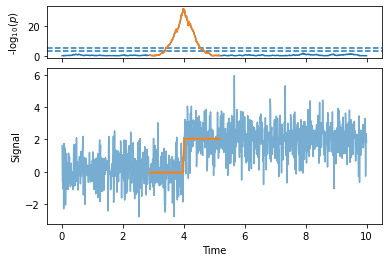

In [47]:
# Look for steps in the trace
fs = fit_signal(trace,dt=dt)
# Fit the step
fs.fit()
# Plot the trace and the results of the t-test method
fs.plot()
fs.print_fit_report()

Once again, the fit does well by making the step width (sigma) very small (0.05), but we can enforce this during the fit.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 231
    # variables        = 3
    chi-square         = 235.708449
    reduced chi-square = 1.03380899
    Akaike info crit   = 10.6611053
    Bayesian info crit = 20.9883584
##  Warning: uncertainties could not be estimated:
    s0_center:     at initial value
[[Variables]]
    s0_c:         -0.04460268 (init = 0.1062227)
    s0_amplitude:  2.05917033 (init = 1.938494)
    s0_center:     3.98000000 (init = 3.98)
    s0_sigma:      0 (fixed)


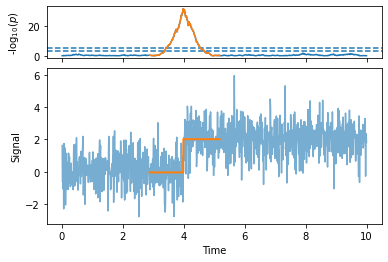

In [49]:
# Look for steps in the trace
fs = fit_signal(trace,dt=dt)
# Fit the step and force the step width to be zero
fs.fit(fixed_step_width = 0)
# Plot the trace and the results of the t-test method
fs.plot()
fs.print_fit_report()

The reduced chi-square has increased slightly but not enough to be significant. The Bayesian info crit, which balances the quality of the fit with the number of parameters has decreased, which suggests that the sigma parameter wasn't helping.